In [1]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.ticker as tkr

import time

import sys
sys.path.append('../velocileptors/')

from zeldovich_bispectrum import ZeldovichBispectrum

In [2]:
Dfac = 1.0

klin, plin = np.loadtxt('planck_pk.txt', unpack=True);

lpt = ZeldovichBispectrum(klin, Dfac * plin)

## Figure 6

In [3]:
knw, pnw = np.loadtxt('planck_pnw_bspline.txt', unpack=True)

lpt_nw = ZeldovichBispectrum(knw, Dfac * pnw)

(-10.0, 20.0)

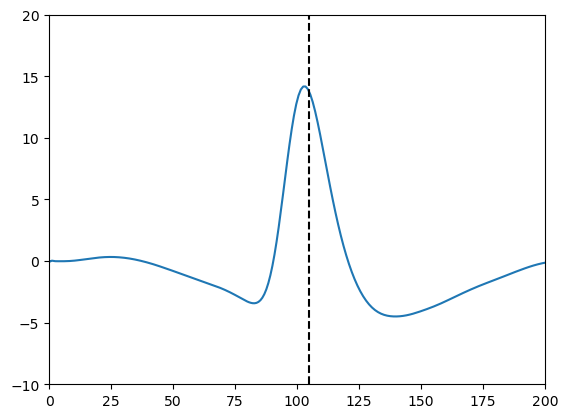

In [4]:
xi_w = lpt.corlin - lpt_nw.corlin

rd = 105

plt.plot(lpt.qint, lpt.qint**2 * xi_w)

plt.plot(rd*np.ones(2),[-10,20],'k--')

plt.xlim(0,200)
plt.ylim(-10,20)

In [5]:
from scipy.interpolate import interp1d

kvec = np.arange(0.01, 0.31, 0.0025)
pwzel = np.zeros_like(kvec)

for ii, k in enumerate(kvec):

    ksq = k**2; kcu = k**3; k4 = k**4
    expon = np.exp(-0.5*ksq * (lpt_nw.XYlin - lpt_nw.sigma))
    suppress = np.exp(-0.5 * ksq *lpt_nw.sigma)
        
    ret = np.zeros(lpt_nw.num_power_components)
        
    bias_integrands = np.zeros( (lpt_nw.num_power_components,lpt_nw.N)  )
        
    for l in range(lpt_nw.jn):

        bias_integrands[0,:] = xi_w

        # multiply by IR exponent
        if l == 0:
            bias_integrands = bias_integrands * expon
            bias_integrands -= bias_integrands[:,-1][:,None] # note that expon(q = infinity) = 1
        else:
            bias_integrands = bias_integrands * expon * lpt_nw.yq**l
            
        # do FFTLog
        ktemps, bias_ffts = lpt_nw.sph.sph(l, bias_integrands)
        ret +=  k**l * interp1d(ktemps, bias_ffts)(k)
    
    
    pwzel[ii] = 4*suppress*np.pi*ret[0]

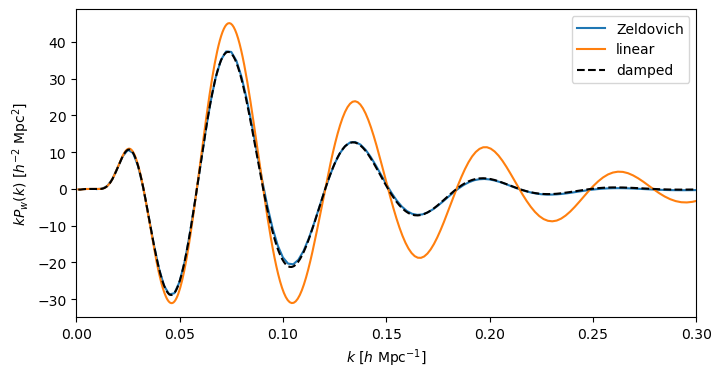

In [6]:
plt.figure(figsize=(8,4))

plt.plot(kvec, kvec * pwzel, label='Zeldovich')

plt.plot(klin, klin * (plin - pnw), label='linear')

Sigma2 = np.interp(rd, lpt.qint, lpt.XYlin)
plt.plot(klin, klin * (plin - pnw) * np.exp(-0.5*klin**2*Sigma2), 'k--', label='damped')

plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$]')
plt.ylabel(r'$k P_w(k)$ [$h^{-2}$ Mpc$^2$]')

plt.legend()

plt.xlim(0,0.3)
plt.savefig('power_spectrum_wiggles.pdf')

## Figure 8

In [7]:
dx = 0.05
eps = 0.02

x2s = np.arange(0, 1.0+dx, dx); x2s = (1 - 2*eps)*x2s + 1.5 * eps
x3s = np.arange(0, 1.0+dx, dx); x3s = (1 - 2*eps)*x3s + eps

X2s, X3s = np.meshgrid(x2s, x3s);
Bs = np.zeros_like(X2s)
mask = np.ones_like(X2s)


for ii, x2 in enumerate(x2s):
    for jj, x3 in enumerate(x3s):
                
        if x2 >= x3 - eps and (x2 + x3) >= 1 - eps:
            mask[jj, ii] = 0

In [8]:
Btreesa = np.zeros_like(X2s)
Bloopa = np.zeros_like(X2s)
BZela = np.zeros_like(X2s)

Bnwtreesa = np.zeros_like(X2s)
Bnwloopa = np.zeros_like(X2s)
BnwZela = np.zeros_like(X2s)


k1a = 0.1

for ii, x2 in enumerate(x2s):
    for jj, x3 in enumerate(x3s):
        
        if x2 >= x3 and (x2 + x3) >= 1:
            cos_thetac = (1 + x2**2 - x3**2)/(2*x2)
            sin_thetac = np.sqrt(1 - cos_thetac**2)
            
            k1vec = k1a * np.array([0,0,1])
            k2vec = -x2 * k1a * np.array([sin_thetac, 0, cos_thetac]) 
            
            Btreesa[jj,ii], xx = lpt.Btree({1: k1vec, 2:k2vec, 3:-k1vec-k2vec})
            
            Binf, Bfin = lpt.B1loop({1: k1vec, 2:k2vec, 3:-k1vec-k2vec})
            Bloopa[jj,ii] = Binf + Bfin
            
            Binf, Bfin = lpt.Bzel({1: k1vec, 2:k2vec, 3:-k1vec-k2vec})
            BZela[jj,ii] = Binf + Bfin
            
            Bnwtreesa[jj,ii], xx = lpt_nw.Btree({1: k1vec, 2:k2vec, 3:-k1vec-k2vec})
            
            Binf, Bfin = lpt_nw.B1loop({1: k1vec, 2:k2vec, 3:-k1vec-k2vec})
            Bnwloopa[jj,ii] = Binf + Bfin
            
            Binf, Bfin = lpt_nw.Bzel({1: k1vec, 2:k2vec, 3:-k1vec-k2vec})
            BnwZela[jj,ii] = Binf + Bfin

In [9]:
Btreesb = np.zeros_like(X2s)
Bloopb = np.zeros_like(X2s)
BZelb = np.zeros_like(X2s)

Bnwtreesb = np.zeros_like(X2s)
Bnwloopb = np.zeros_like(X2s)
BnwZelb = np.zeros_like(X2s)


k1b = 0.2

for ii, x2 in enumerate(x2s):
    for jj, x3 in enumerate(x3s):
        
        if x2 >= x3 and (x2 + x3) >= 1:
            cos_thetac = (1 + x2**2 - x3**2)/(2*x2)
            sin_thetac = np.sqrt(1 - cos_thetac**2)
            
            k1vec = k1b * np.array([0,0,1])
            k2vec = -x2 * k1b * np.array([sin_thetac, 0, cos_thetac]) 
            
            Btreesb[jj,ii], xx = lpt.Btree({1: k1vec, 2:k2vec, 3:-k1vec-k2vec})
            
            Binf, Bfin = lpt.B1loop({1: k1vec, 2:k2vec, 3:-k1vec-k2vec})
            Bloopb[jj,ii] = Binf + Bfin
            
            Binf, Bfin = lpt.Bzel({1: k1vec, 2:k2vec, 3:-k1vec-k2vec})
            BZelb[jj,ii] = Binf + Bfin
            
            Bnwtreesb[jj,ii], xx = lpt_nw.Btree({1: k1vec, 2:k2vec, 3:-k1vec-k2vec})
            
            Binf, Bfin = lpt_nw.B1loop({1: k1vec, 2:k2vec, 3:-k1vec-k2vec})
            Bnwloopb[jj,ii] = Binf + Bfin
            
            Binf, Bfin = lpt_nw.Bzel({1: k1vec, 2:k2vec, 3:-k1vec-k2vec})
            BnwZelb[jj,ii] = Binf + Bfin

/var/folders/sd/nbzbxs0j4xg86gnmcbpk7mq00000gq/T/ipykernel_36782/1972452137.py:9: RuntimeWarning: invalid value encountered in true_divide
  plt.contourf(X3s, X2s, np.ma.array( Btreesa/Bnwtreesa - 1, mask=mask), levels=levels, cmap='coolwarm')
/var/folders/sd/nbzbxs0j4xg86gnmcbpk7mq00000gq/T/ipykernel_36782/1972452137.py:28: RuntimeWarning: invalid value encountered in true_divide
  ax[3,0].contourf(X3s, X2s, np.ma.array( (Bloopa-Bnwloopa)/Btreesa, mask=mask),  levels=levels, cmap='coolwarm')
/var/folders/sd/nbzbxs0j4xg86gnmcbpk7mq00000gq/T/ipykernel_36782/1972452137.py:43: RuntimeWarning: invalid value encountered in true_divide
  plt.contourf(X3s, X2s, np.ma.array( (BZela-BnwZela)/Btreesa, mask=mask), levels=levels, cmap='coolwarm')
/var/folders/sd/nbzbxs0j4xg86gnmcbpk7mq00000gq/T/ipykernel_36782/1972452137.py:66: RuntimeWarning: invalid value encountered in true_divide
  plt.contourf(X3s, X2s, np.ma.array( Btreesb/Bnwtreesb - 1, mask=mask), levels=levels, cmap='coolwarm')
/var/folde

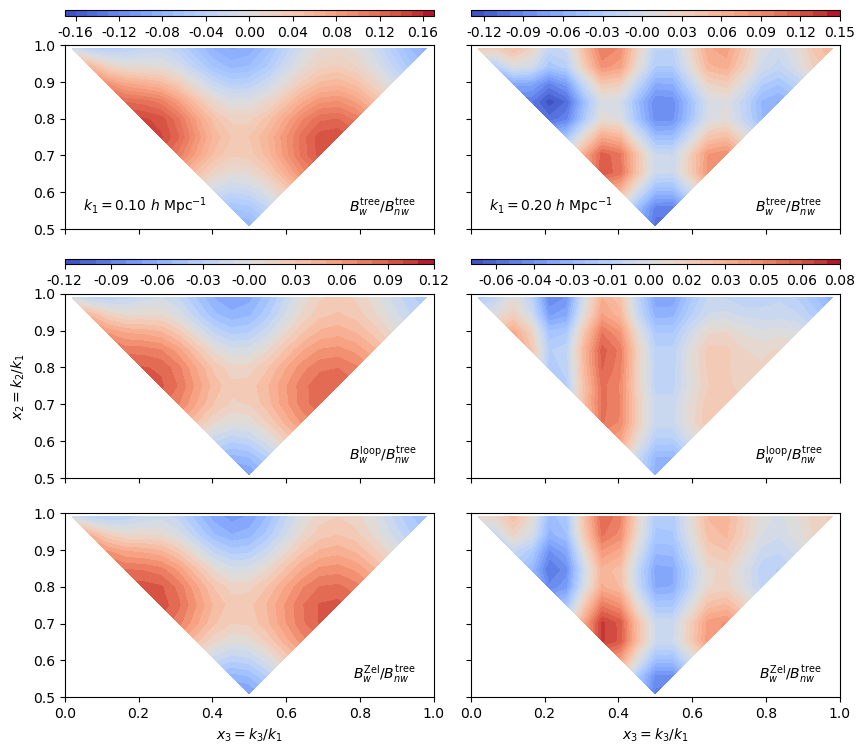

In [10]:
gridspec = {'height_ratios': [0.03, 1, 0.03, 1, 1],'width_ratios':[1,1],'hspace':0.2, 'wspace':0.1}
fig, ax = plt.subplots(5,2, figsize=(10,9), gridspec_kw=gridspec)

#### Left Panels
levels = np.arange(-0.17, 0.18, 0.01)

plt.sca(ax[1,0])

plt.contourf(X3s, X2s, np.ma.array( Btreesa/Bnwtreesa - 1, mask=mask), levels=levels, cmap='coolwarm')

ax[1,0].axis('square')

ax[1,0].set_xlim(0,1.0)
ax[1,0].set_ylim(0.5, 1)

ax[1,0].set_xticklabels([])

ax[1,0].text(0.05, 0.55, r'$k_1 = $%.2f $h$ Mpc$^{-1}$'%(k1a))
ax[1,0].text(0.77, 0.55, r'$B^{\rm tree}_w/B^{\rm tree}_{nw}$')

cax = ax[0,0]
cbar = plt.colorbar(cax=cax, format=tkr.FormatStrFormatter('%.2f'), orientation='horizontal')
#cbar.set_ticks(np.arange(-0.17, 0.181, 0.05)) 
#cbar.ax.xaxis.set_ticks_position("top")

levels = np.arange(-0.12, 0.13, 0.01)

ax[3,0].contourf(X3s, X2s, np.ma.array( (Bloopa-Bnwloopa)/Btreesa, mask=mask),  levels=levels, cmap='coolwarm')
ax[3,0].text(0.77, 0.55,r'$B^{\rm loop}_{w}/B^{\rm tree}_{nw}$')

ax[3,0].axis('square')

ax[3,0].set_xlim(0,1.0)
ax[3,0].set_ylim(0.5, 1)

ax[3,0].set_xticklabels([])

ax[3,0].set_ylabel(r'$x_2 = k_2 / k_1$')


plt.sca(ax[4,0])

plt.contourf(X3s, X2s, np.ma.array( (BZela-BnwZela)/Btreesa, mask=mask), levels=levels, cmap='coolwarm')
plt.text(0.78, 0.55, r'$B^{\rm Zel}_{w}/B^{\rm tree}_{nw}$')
plt.xlabel(r'$x_3 = k_3 / k_1$')


ax[4,0].axis('square')

ax[4,0].set_xlim(0,1.0)
ax[4,0].set_ylim(0.5, 1)


cax = ax[2,0]
cbar = plt.colorbar(cax=cax,\
                    format=tkr.FormatStrFormatter('%.2f'), orientation='horizontal')
#cbar.set_ticks(np.arange(-0.13, 0.14, 0.03))



##### Right panels
levels = np.arange(-0.13, 0.15, 0.01)

plt.sca(ax[1,1])

plt.contourf(X3s, X2s, np.ma.array( Btreesb/Bnwtreesb - 1, mask=mask), levels=levels, cmap='coolwarm')

ax[1,1].axis('square')

ax[1,1].set_xlim(0,1.0)
ax[1,1].set_ylim(0.5, 1)

ax[1,1].set_xticklabels([])

ax[1,1].text(0.05, 0.55, r'$k_1 = $%.2f $h$ Mpc$^{-1}$'%(k1b))
ax[1,1].text(0.77, 0.55, r'$B^{\rm tree}_w/B^{\rm tree}_{nw}$')

ax[1,1].set_yticklabels([])

cax = ax[0,1]
cbar = plt.colorbar(cax=cax, format=tkr.FormatStrFormatter('%.2f'), orientation='horizontal')
#cbar.set_ticks(np.arange(6.3, 8.4, 0.5)) 

levels = np.arange(-0.07, 0.075, 0.005)

ax[3,1].contourf(X3s, X2s, np.ma.array( (Bloopb-Bnwloopb)/Bnwtreesb, mask=mask),  levels=levels, cmap='coolwarm')
ax[3,1].text(0.77, 0.55,r'$B^{\rm loop}_{w}/B^{\rm tree}_{nw}$')

ax[3,1].axis('square')

ax[3,1].set_xlim(0,1.0)
ax[3,1].set_ylim(0.5, 1)

ax[3,1].set_xticklabels([])
ax[3,1].set_yticklabels([])


plt.sca(ax[4,1])

plt.contourf(X3s, X2s, np.ma.array( (BZelb-BnwZelb)/Bnwtreesb, mask=mask), levels=levels, cmap='coolwarm')
plt.text(0.78, 0.55, r'$B^{\rm Zel}_{w}/B^{\rm tree}_{nw}$')
plt.xlabel(r'$x_3 = k_3 / k_1$')


ax[4,1].axis('square')

ax[4,1].set_xlim(0,1.0)
ax[4,1].set_ylim(0.5, 1)

ax[4,1].set_yticklabels([])

cax = ax[2,1]
cbar = plt.colorbar(cax=cax,\
                    format=tkr.FormatStrFormatter('%.2f'), orientation='horizontal')
#cbar.set_ticks(np.arange(0.6, 1.9, 0.4))

plt.savefig('triangle_plots_wiggles.pdf',bbox_inches='tight',pad_inches = 0.25,)

## Figure 9

In [11]:
from velocileptors.Utils.loginterp import loginterp

#plinfunc = interp1d(klin, Dfac * plin, kind='cubic', bounds_error=False, fill_value=1)
#pnwfunc = interp1d(klin, Dfac * pnw, kind='cubic', bounds_error=False, fill_value=1)
plinfunc = loginterp(klin, Dfac * plin)
pnwfunc = loginterp(klin, Dfac * pnw)
pwfunc = interp1d(klin, Dfac * (plin - pnw), kind='cubic', bounds_error=False, fill_value=1)

def Z2(p1vec, p2vec):
    return 0.5 * (1 + np.dot(p1vec,p2vec)/np.dot(p1vec,p1vec)) * (1 + np.dot(p1vec,p2vec)/np.dot(p2vec,p2vec))
    #return 5./7 + 0.5 * (np.dot(p1vec,p2vec)/np.dot(p1vec,p1vec) + np.dot(p1vec,p2vec)/np.dot(p2vec,p2vec))\
    #            + 2./7*np.dot(p1vec,p2vec)**2/np.dot(p2vec,p2vec)/np.dot(p1vec,p1vec)
    #return np.dot(p1vec,p2vec)**2/np.dot(p2vec,p2vec)/np.dot(p1vec,p1vec) - 1./3
    #return 1
    
def Btree(p1vec, p2vec, pfunc=plinfunc):
    
    p3vec = - (p1vec+p2vec)
    p1, p2, p3 = np.linalg.norm(p1vec), np.linalg.norm(p2vec), np.linalg.norm(p3vec)
    
    
    return 2 * (  Z2(p1vec,p2vec) * pfunc(p1) * pfunc(p2)\
                + Z2(p2vec,p3vec) * pfunc(p2) * pfunc(p3)\
                + Z2(p1vec,p3vec) * pfunc(p1) * pfunc(p3))

In [12]:
SigmaBAO = np.interp(rd, lpt.qint, lpt.Xlin + lpt.Ylin)

#pdampedfunc = interp1d(klin, Dfac * (pnw + np.exp(-0.5*klin**2*SigmaBAO) *(plin - pnw)),\
#                       kind='cubic', bounds_error=False, fill_value=1)

pdampedfunc = loginterp(klin, Dfac * (pnw + np.exp(-0.5*klin**2*SigmaBAO) *(plin - pnw)))

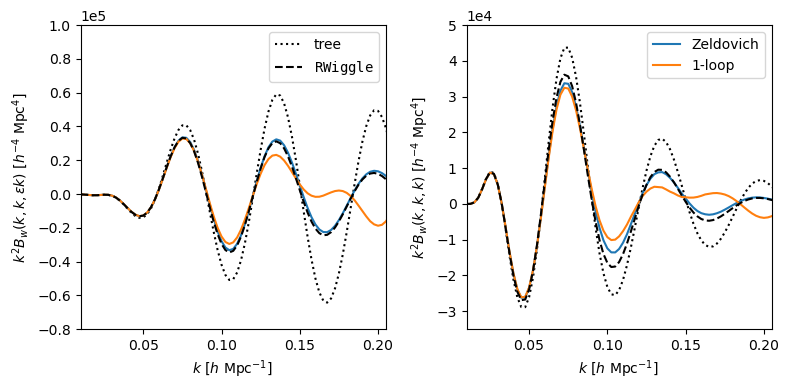

In [13]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,2)

p1hat = np.array([1,0,0])
p2hat = -np.array([0.5, np.sqrt(3)/2,0])

ks = np.arange(0.01, 0.21, 0.0025)

Btrees = np.zeros_like(ks)
Btreenws = np.zeros_like(ks)
Bdamped = np.zeros_like(ks)

for ii, k in enumerate(ks):
    
    Btrees[ii] = Btree(k*p1hat, k*p2hat, pfunc=plinfunc)
    Btreenws[ii] = Btree(k*p1hat, k*p2hat, pfunc=pnwfunc)
    Bdamped[ii] = Btree(k*p1hat, k*p2hat, pfunc=pdampedfunc)
    
Bs = np.zeros_like(ks)
Bnws = np.zeros_like(ks)

for ii, k in enumerate(ks):
    
    Binf, Bfin = lpt.Bzel({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bs[ii] = Binf + Bfin

    Binf, Bfin = lpt_nw.Bzel({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bnws[ii] = Binf + Bfin
    
Bloops = np.zeros_like(ks)
Bloopnws = np.zeros_like(ks)

for ii, k in enumerate(ks):
    
    Binf, Bfin = lpt.B1loop({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bloops[ii] = Binf + Bfin

    Binf, Bfin = lpt_nw.B1loop({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bloopnws[ii] = Binf + Bfin

plt.plot(ks, ks**2 * (Btrees-Btreenws),'k:')
plt.plot(ks, ks**2 * (Bs-Bnws), label='Zeldovich')
plt.plot(ks, ks**2 * (Bloops-Bloopnws), label='1-loop')
plt.plot(ks, ks**2 * (Bdamped-Btreenws), 'k--')


plt.ylim(-Dfac**2*35000, Dfac**2*50000)

plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))


plt.xlim(0.01,0.205)
plt.legend()

plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$] ')
plt.ylabel(r'$k^2 B_w(k,k,k)$ [$h^{-4}$ Mpc$^{4}$] ')

# save data
np.savetxt('equilateral_wiggle_curves.txt',\
           np.array([ks, Btrees, Btreenws, Bs, Bnws, Bloops, Bloopnws, Bdamped]).T,\
           header='k\t Btree\t Btreenw\t BZel\t BZelnw\t Bloop\t Bloopnw\ Bdamped\n')


np.savetxt('equilateral_wiggle_curves.txt',\
           np.array([ks, Btrees, Btreenws, Bs, Bnws, Bloops, Bloopnws, Bdamped]).T,\
           header='Triangle Configuration is k x ' + str(p1hat) + ', ' + str(p2hat) + '\n'  +\
                  'k\t Btree\t Btreenw\t BZel\t BZelnw\t Bloop\t Bloopnw\ Bdamped')

plt.subplot(1,2,1)

p1hat = np.array([-0.025,0,1])
p2hat = np.array([0.05, 0, 0])

Btrees = np.zeros_like(ks)
Btreenws = np.zeros_like(ks)
Bdamped = np.zeros_like(ks)

for ii, k in enumerate(ks):
    
    Btrees[ii] = Btree(k*p1hat, k*p2hat, pfunc=plinfunc)
    Btreenws[ii] = Btree(k*p1hat, k*p2hat, pfunc=pnwfunc)
    Bdamped[ii] = Btree(k*p1hat, k*p2hat, pfunc=pdampedfunc)
    
Bs = np.zeros_like(ks)
Bnws = np.zeros_like(ks)

for ii, k in enumerate(ks):
    
    Binf, Bfin = lpt.Bzel({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bs[ii] = Binf + Bfin

    Binf, Bfin = lpt_nw.Bzel({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bnws[ii] = Binf + Bfin
    
Bloops = np.zeros_like(ks)
Bloopnws = np.zeros_like(ks)

for ii, k in enumerate(ks):
    
    Binf, Bfin = lpt.B1loop({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bloops[ii] = Binf + Bfin

    Binf, Bfin = lpt_nw.B1loop({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bloopnws[ii] = Binf + Bfin
    
plt.plot(ks, ks**2 * (Btrees-Btreenws),'k:',label='tree')
plt.plot(ks, ks**2 * (Bs-Bnws))
plt.plot(ks, ks**2 * (Bloops-Bloopnws))
plt.plot(ks, ks**2 * (Bdamped-Btreenws),'k--', label=r'$\tt{RWiggle}$')


plt.ylim(-Dfac**2*80000, Dfac**2*100000)
plt.xlim(0.01,0.205)

plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))


plt.legend(loc='upper right')

plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$] ')
plt.ylabel(r'$k^2 B_w(k,k,\epsilon k)$ [$h^{-4}$ Mpc$^{4}$] ')

plt.tight_layout()

np.savetxt('squeezed_wiggle_curves.txt',\
           np.array([ks, Btrees, Btreenws, Bs, Bnws, Bloops, Bloopnws, Bdamped]).T,\
           header='Triangle Configuration is k x ' + str(p1hat) + ', ' + str(p2hat) + '\n'  +\
                  'k\t Btree\t Btreenw\t BZel\t BZelnw\t Bloop\t Bloopnw\ Bdamped')

plt.savefig('squeezed_equilateral_wiggle.pdf')

## Figure 10

In [14]:
from zeldovich_bispectrum_ept import ZeldovichBispectrumEPT

ept = ZeldovichBispectrumEPT(klin, Dfac * plin, pnw=Dfac * pnw, kint_max=0.5)

ept_nw = ZeldovichBispectrumEPT(klin, Dfac * pnw, kint_max=0.5)

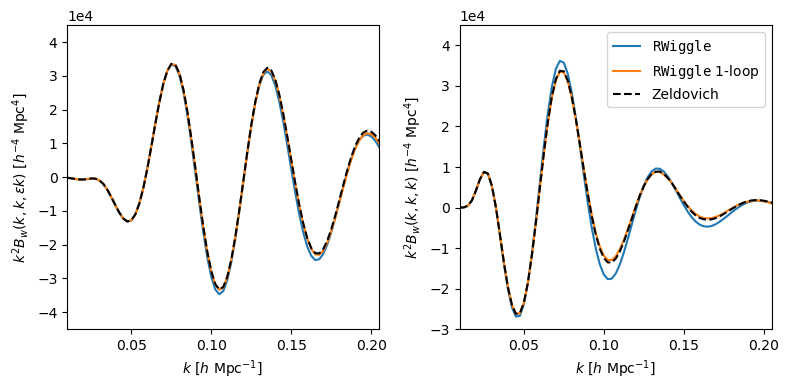

In [15]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,2)

p1hat = np.array([1,0,0])
p2hat = -np.array([0.5, np.sqrt(3)/2,0])

ks = np.arange(0.01, 0.21, 0.0025)

Btrees = np.zeros_like(ks)
Btrees_noresum = np.zeros_like(ks)
Btreenws = np.zeros_like(ks)

for ii, k in enumerate(ks):

    Btrees[ii] = Btree(k*p1hat, k*p2hat, pfunc=ept.pfunc_resummed1)
    Btrees_noresum[ii] = Btree(k*p1hat, k*p2hat, pfunc=ept.pfunc)
    Btreenws[ii] = ept_nw.Btree({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})[0]
    
    
Bloops = np.zeros_like(ks)
Bloopnws = np.zeros_like(ks)

Bzels = np.zeros_like(ks)
Bzelnws = np.zeros_like(ks)


for ii, k in enumerate(ks):
    
    Binf, Bfin = ept.B1loop({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bloops[ii] = Binf + Bfin

    Binf, Bfin = ept_nw.B1loop({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bloopnws[ii] = Binf + Bfin
    
    Binf, Bfin = lpt.Bzel({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bzels[ii] = Binf + Bfin

    Binf, Bfin = lpt_nw.Bzel({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bzelnws[ii] = Binf + Bfin

plt.plot(ks, ks**2 * (Btrees-Btreenws),'C0', label=r'$\tt{RWiggle}$')
#plt.plot(ks, ks**2 * (Bs-Bnws), label='Zeldovich')
plt.plot(ks, ks**2 * (Bloops-Bloopnws), 'C1',label=r'$\tt{RWiggle}$ 1-loop')

plt.plot(ks, ks**2 * (Bzels-Bzelnws), 'k--',label='Zeldovich')

#plt.plot(ks, ks**2 * (Btrees_noresum-Btreenws),'k:', label=r'linear')


#plt.plot(ks, ks**2 * (Bdamped-Btreenws), 'C1--')

plt.xlim(0.01,0.205)
plt.legend()

plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$] ')
plt.ylabel(r'$k^2 B_w(k,k,k)$ [$h^{-4}$ Mpc$^{4}$] ')
    
plt.ylim(-Dfac**2*30000, Dfac**2*45000)

plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))


plt.xlim(0.01,0.205)
plt.legend()

plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$] ')
plt.ylabel(r'$k^2 B_w(k,k,k)$ [$h^{-4}$ Mpc$^{4}$] ')

    
plt.subplot(1,2,1)

p1hat = np.array([-0.025,0,1])
p2hat = np.array([0.05, 0, 0])

ks = np.arange(0.01, 0.21, 0.0025)

Btrees = np.zeros_like(ks)
Btreenws = np.zeros_like(ks)

for ii, k in enumerate(ks):

    Btrees[ii] = Btree(k*p1hat, k*p2hat, pfunc=ept.pfunc_resummed1)
    Btrees_noresum[ii] = Btree(k*p1hat, k*p2hat, pfunc=ept.pfunc)
    Btreenws[ii] = ept_nw.Btree({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})[0]
    
    
Bloops = np.zeros_like(ks)
Bloopnws = np.zeros_like(ks)

Bzels = np.zeros_like(ks)
Bzelnws = np.zeros_like(ks)


for ii, k in enumerate(ks):
    
    Binf, Bfin = ept.B1loop({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bloops[ii] = Binf + Bfin

    Binf, Bfin = ept_nw.B1loop({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bloopnws[ii] = Binf + Bfin
    
    Binf, Bfin = lpt.Bzel({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bzels[ii] = Binf + Bfin

    Binf, Bfin = lpt_nw.Bzel({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bzelnws[ii] = Binf + Bfin

plt.plot(ks, ks**2 * (Btrees-Btreenws),'C0', label=r'$\tt{RWiggle}$')
#plt.plot(ks, ks**2 * (Bs-Bnws), label='Zeldovich')
plt.plot(ks, ks**2 * (Bloops-Bloopnws), 'C1',label=r'$\tt{RWiggle}$ 1-loop')

plt.plot(ks, ks**2 * (Bzels-Bzelnws), 'k--',label='Zeldovich')

#plt.plot(ks, ks**2 * (Btrees_noresum-Btreenws),'k:', label=r'linear')


plt.ylim(-Dfac**2*45000, Dfac**2*45000)
plt.xlim(0.01,0.205)

plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))


#plt.legend(loc='upper right')

plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$] ')
plt.ylabel(r'$k^2 B_w(k,k,\epsilon k)$ [$h^{-4}$ Mpc$^{4}$] ')

plt.tight_layout()

plt.savefig('ept_1loop_wiggles.pdf')